**Main Focus**: differential abundance testing of cell type clusters (U-space) between treatment conditions (age / days since shot)

**Additional**
1) degree of integration: do the same cell types end up in the same clusters

# Peak at data, run GPU stuff

In [1]:
import os, anndata, pickle
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib as mpl
%matplotlib inline
plt.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
import seaborn as sns
datadir = './OLD_DATA'

adata_path = os.path.join(datadir, 'sound_life_t_cd4_memory_with_embeddings_no_X.h5ad')
adata = anndata.read_h5ad(adata_path, backed='r')
with open('u_embeddings.pkl', 'rb') as fin:
    u = pickle.load(fin)

adata.obsm['u'] = u

**obs**
1) barcodes
    - cell barcode?
2) original barcodes
3) cell_name 
4) batch_id, pool_id, chip_id, well_id
5) n_genes, n_reads, n_umis
6) total_counts_mito, pct_counts_mito, doublet_score, 
    - QC metrics. data came pre-processed
7) predicted_AIFI_L1
8) AIFI_L1_score
9) AIFI_L1
10) ..... AIFI_L3
    - these are the predicted labels 
11) 'sample.sampleKitGuid', 'cohort.cohortGuid', 'subject.subjectGuid', 
12) 'subject.biologicalSex', 
13) 'subject.cmv', 
14) 'subject.bmi', 
15) 'subject.race', 
16) 'subject.ethnicity', 
17) 'subject.birthYear',
18) 'subject.ageAtFirstDraw',
19) 'sample.visitName',
20) 'sample.drawYear',
21) 'sample.subjectAgeAtDraw',
22) 'specimen.specimenGuid',
23) 'pipeline.fileGuid'
24) 'subject.ageGroup'
25) '_indices', '_scvi_sample', '_scvi_batch', '_scvi_labels'

In [2]:
obs = adata.obs.copy()
print(obs.columns)
obs.drop(columns = obs.columns[0:7]).head()
# get rid of some useless columns 
obs.drop(columns = [x for x in obs.columns if '_L1' in x or '_L2' in x] + ['barcodes',
     'original_barcodes', 'cell_name','pipeline.fileGuid',
      '_indices', '_scvi_sample', '_scvi_batch', '_scvi_labels', 'subject.birthYear',
      'specimen.specimenGuid'], inplace = True)

Index(['barcodes', 'original_barcodes', 'cell_name', 'batch_id', 'pool_id',
       'chip_id', 'well_id', 'n_genes', 'n_reads', 'n_umis',
       'total_counts_mito', 'pct_counts_mito', 'doublet_score',
       'predicted_AIFI_L1', 'AIFI_L1_score', 'AIFI_L1', 'predicted_AIFI_L2',
       'AIFI_L2_score', 'AIFI_L2', 'predicted_AIFI_L3', 'AIFI_L3_score',
       'AIFI_L3', 'sample.sampleKitGuid', 'cohort.cohortGuid',
       'subject.subjectGuid', 'subject.biologicalSex', 'subject.cmv',
       'subject.bmi', 'subject.race', 'subject.ethnicity', 'subject.birthYear',
       'subject.ageAtFirstDraw', 'sample.visitName', 'sample.drawYear',
       'sample.subjectAgeAtDraw', 'specimen.specimenGuid', 'pipeline.fileGuid',
       'subject.ageGroup', '_indices', '_scvi_sample', '_scvi_batch',
       '_scvi_labels'],
      dtype='object')


## Export U matrix for creating a UMAP


In [3]:
umat = pd.DataFrame(adata.obsm['u'])
umat.index = adata.obs['barcodes']
with open('umat.pkl', 'wb') as f:
    pickle.dump(umat, f)

KeyError: 'u'

read UMAP, leiden clusters
- run on colab for cuda accel

In [34]:
with open('U_umap_n15_md0_3.pkl', 'rb') as f:
    u_umap = pickle.load(f)
u_umap = u_umap.join(obs[[x for x in obs.columns if 'AIFI' in x]])

u_clusters = pd.read_csv('parts.res0_2.tsv', sep = '\t', index_col = 0)
u_clusters.sort_values(by = 'vertex', inplace = True)
u_clusters.index = umat.index
#join
u_umap = u_umap.join(u_clusters[['partition']].astype('category'))

## read in the UMAPs, leiden clusters (also on colab for accel)

In [ ]:
u_umap = pd.read_csv('u_UMAP.csv', index_col=0)
adata.obsm['u_umap'] = u_umap.to_numpy()
adata.obs['UMAP0'] = u_umap['U_UMAP0']
adata.obs['UMAP1'] = u_umap['U_UMAP1']
adata.obs['partition'] = pd.read_csv('parts.res0_2.tsv', sep = '\t', index_col=0)['partition'].to_numpy()

## UMAP plots

**Allen institute expert labeling**
1) PCA + Harmony integration, Leiden clustering.
2) assign clusters to major cell classes with scanpy.tl.rank_genes_groups (major cell classes)
    - use fraction of cells in cluster expressing marker as metric 
3) additional unspecified iterative clustering
4) Allen institute experts used marker genes to assign cell type identities AIFI clusters
5) Train CellTypist o generate labeling models 

In [12]:
aifi_colors = dict(zip(adata.obs['AIFI_L3'].unique().tolist(),
['C5', 'C6', 'C7', 'C8', 'C9']))

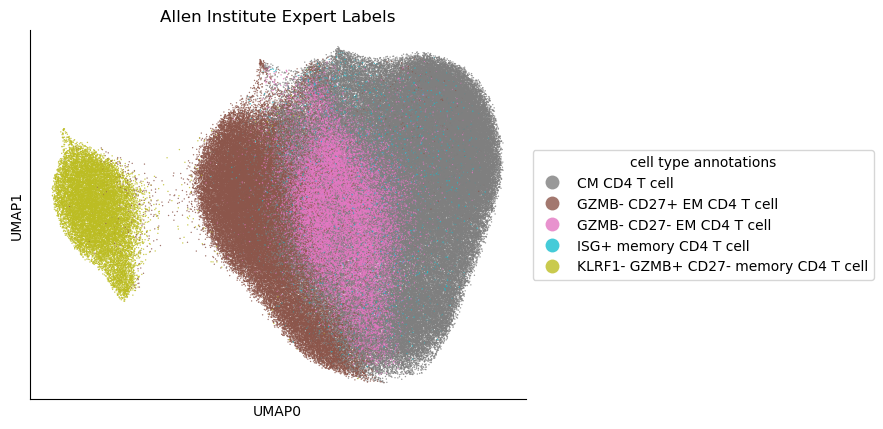

In [13]:
fig, ax = plt.subplots()
scatter = sns.scatterplot(
    x='UMAP0',
    y='UMAP1',
    data=adata.obs.iloc[::10],
    hue='AIFI_L3',
    palette=aifi_colors,
    alpha=0.8,
    edgecolor='none',
    s=1
)

# Make legend marker size large
legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), scatterpoints=1,
 markerscale=10, title = 'cell type annotations')

sns.despine()
plt.xticks([])
plt.yticks([])
plt.title('Allen Institute Expert Labels')

plt.show()

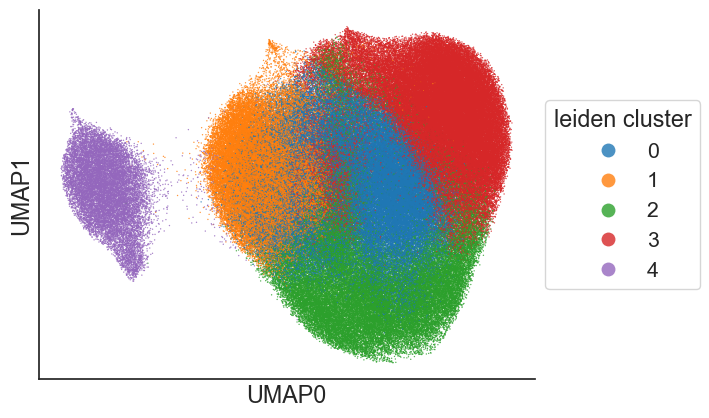

In [34]:
fig, ax = plt.subplots()
scatter = sns.scatterplot(x='UMAP0', y='UMAP1', data = adata.obs.iloc[::10], hue = 'partition',
                         alpha = 0.8, edgecolor = 'none', s = 1, palette = 'tab10')

# Make legend marker size large
legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), scatterpoints=1, markerscale=10,
title = 'leiden cluster')
sns.despine()
plt.xticks([])
plt.yticks([])
plt.show()
os.makedirs('figures', exist_ok = True)
fig.savefig('figures/leiden_umap.pdf', dpi = 300, bbox_inches = 'tight', format = 'pdf', transparent = True)

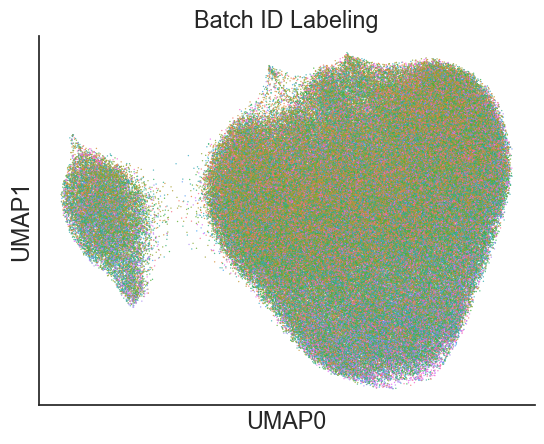

In [22]:
sns.set(style = 'white', font_scale = 1.4)
fig, ax = plt.subplots()

scatter = sns.scatterplot(x='UMAP0', y='UMAP1', 
data = adata.obs.iloc[::10], hue = 'batch_id',
                         alpha = 0.8, edgecolor = 'none', s = 1, legend = False)

# Make legend marker size large
plt.title('Batch ID Labeling')
sns.despine()
plt.xticks([])
plt.yticks([])
plt.show()

/var/folders/_p/0rhlx8c56pgffwnwkjz824s80000gn/T/ipykernel_1227/3387163703.py:17: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


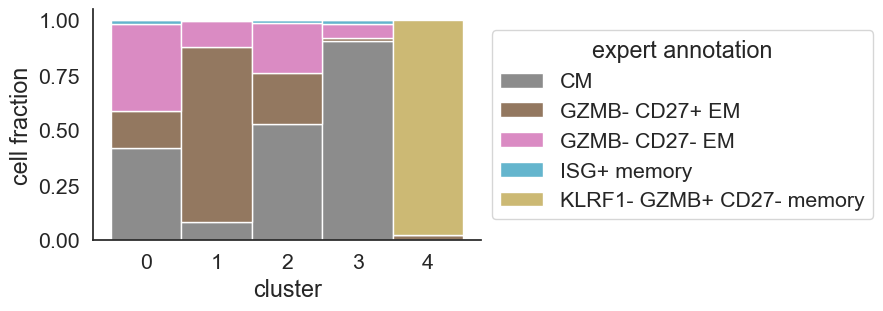

In [38]:
fig, ax = plt.subplots()
barp_data = pd.melt(pd.crosstab(adata.obs['AIFI_L3'], adata.obs['partition']).reset_index(),
id_vars = ['AIFI_L3'], var_name = 'cluster', value_name = 'cells')
# seaborn's sns.barplot does not support stacked bars;
# use pandas .plot(kind='bar', stacked=True) for a stacked barplot

pivot = barp_data.pivot(index='cluster', columns='AIFI_L3', values='cells').fillna(0)
pivot = (pivot.transpose() / pivot.sum(axis = 1)).transpose() 
pivot.columns = [x[:-11] for x in pivot.columns]
colors = aifi_colors
colors = {x[:-11]:colors[x] for x in colors}
pivot.plot(kind='bar', stacked=True, figsize=(5,3), color=colors, legend = True,
width = 1, ax = ax)
plt.xlabel('cluster')
plt.ylabel('cell fraction')
plt.legend(bbox_to_anchor=(1, 0.5), loc='center left', ncol=1, title='expert annotation')
plt.tight_layout()
plt.xticks(rotation = 0)
sns.despine()
plt.show()
fig.savefig('figures/barplot_by_cluster.pdf', dpi = 300, bbox_inches = 'tight', format = 'pdf', transparent = True)

/var/folders/_p/0rhlx8c56pgffwnwkjz824s80000gn/T/ipykernel_1227/1132638922.py:15: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


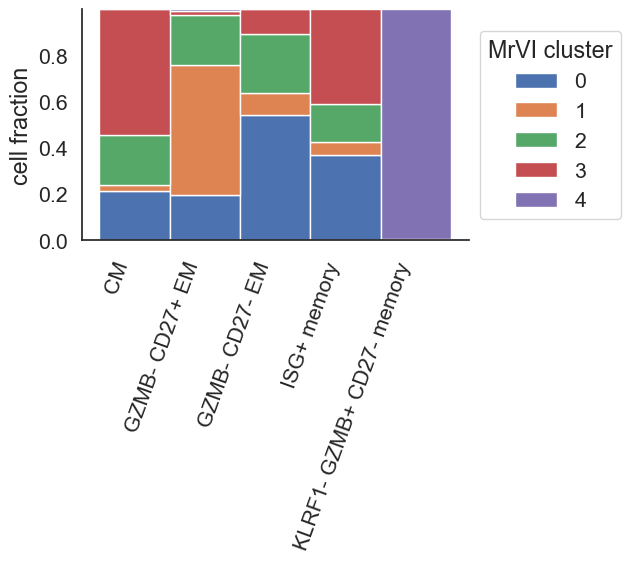

In [43]:
fig, ax = plt.subplots()
barp_data = pd.melt(pd.crosstab(adata.obs['AIFI_L3'], adata.obs['partition']).reset_index(),
id_vars = ['AIFI_L3'], var_name = 'cluster', value_name = 'cells')
# seaborn's sns.barplot does not support stacked bars;
# use pandas .plot(kind='bar', stacked=True) for a stacked barplot

pivot = barp_data.pivot(index='AIFI_L3', columns='cluster', values='cells').fillna(0)
pivot = (pivot.transpose() / pivot.sum(axis = 1)).transpose() 

pivot.plot(kind='bar', stacked=True, figsize=(5,3), legend = True,
width = 1, ax = ax)
plt.xlabel('cluster')
plt.ylabel('cell fraction')
plt.legend(bbox_to_anchor=(1, 0.5), loc='center left', ncol=1, title='MrVI cluster')
plt.tight_layout()
xticks, xlabels = plt.xticks()
new_labels = [label.get_text()[:-10] for label in plt.gca().get_xticklabels()]
plt.xticks(xticks, new_labels, rotation=70, ha='right')
plt.xlabel('')
sns.despine()
plt.show()
fig.savefig('figures/barplot_by_expert.pdf', dpi = 300, bbox_inches = 'tight', format = 'pdf', transparent = True)

## benchmark integration

In [88]:
batch_ids = ['batch_id', 'pool_id', 'chip_id', 'well_id','subject.subjectGuid']
for b in batch_ids:
    if b in u_umap.columns: u_umap.drop(columns = [b], inplace = True)
u_umap = u_umap.join(obs[batch_ids])
u_umap.head()


,UMAP0,UMAP1,predicted_AIFI_L3,AIFI_L3_score,AIFI_L3,partition,batch_id,pool_id,chip_id,well_id,subject.subjectGuid
barcodes,,,,,,,,,,,
6d881d5e3eb811eb83ca221ed6f4a4fb,4.435710,-0.788294,GZMB- CD27+ EM CD4 T cell,0.999998,GZMB- CD27+ EM CD4 T cell,0,B039,B039-P2,B039-P2C3,B039-P2C3W2,BR1012
5c40f7aa3eb811eb8c54d6d536743a60,-2.050968,-9.509706,GZMB- CD27+ EM CD4 T cell,0.999998,GZMB- CD27+ EM CD4 T cell,2,B039,B039-P2,B039-P2C3,B039-P2C3W4,BR1012
f639e2243eb611eb951b52cbef2896a9,3.920224,-5.262460,GZMB- CD27+ EM CD4 T cell,1.000000,GZMB- CD27+ EM CD4 T cell,0,B039,B039-P2,B039-P2C3,B039-P2C3W5,BR1012
0e92983c3ebe11eba760d286b6767d5b,3.795940,-5.398916,GZMB- CD27+ EM CD4 T cell,1.000000,GZMB- CD27+ EM CD4 T cell,0,B039,B039-P2,B039-P2C2,B039-P2C2W5,BR1012
0e92e2423ebe11eba760d286b6767d5b,3.377924,-4.703609,GZMB- CD27+ EM CD4 T cell,1.000000,GZMB- CD27+ EM CD4 T cell,0,B039,B039-P2,B039-P2C2,B039-P2C2W5,BR1012


In [63]:
u_umap[['batch_id', 'pool_id', 'chip_id', 'well_id', 'subject.subjectGuid']].nunique()

batch_id                 99
pool_id                 143
chip_id                 284
well_id                1564
subject.subjectGuid      96
dtype: int64

In [89]:
from scipy.stats import chi2_contingency
import numpy as np
table = pd.crosstab(u_umap['batch_id'], u_umap['partition'])
chi2, p, dof, expected = chi2_contingency(table)
n = table.values.sum()
cramers_v = np.sqrt(chi2 / (n * (min(table.shape)-1)))
print(p, chi2, dof, cramers_v)

0.0 229476.1068757128 392 0.14739940734337562


In [90]:
table = pd.crosstab(u_umap['batch_id'], u_umap['AIFI_L3'])
chi2, p, dof, expected = chi2_contingency(table)
n = table.values.sum()
cramers_v = np.sqrt(chi2 / (n * (min(table.shape)-1)))
print(p, chi2, dof, cramers_v)

0.0 153154.6884688017 392 0.12041820489587296


Text(0.5, 1.0, 'expert labels: $\\chi^2$ = 153154.00, DoF = 3.92e+02')

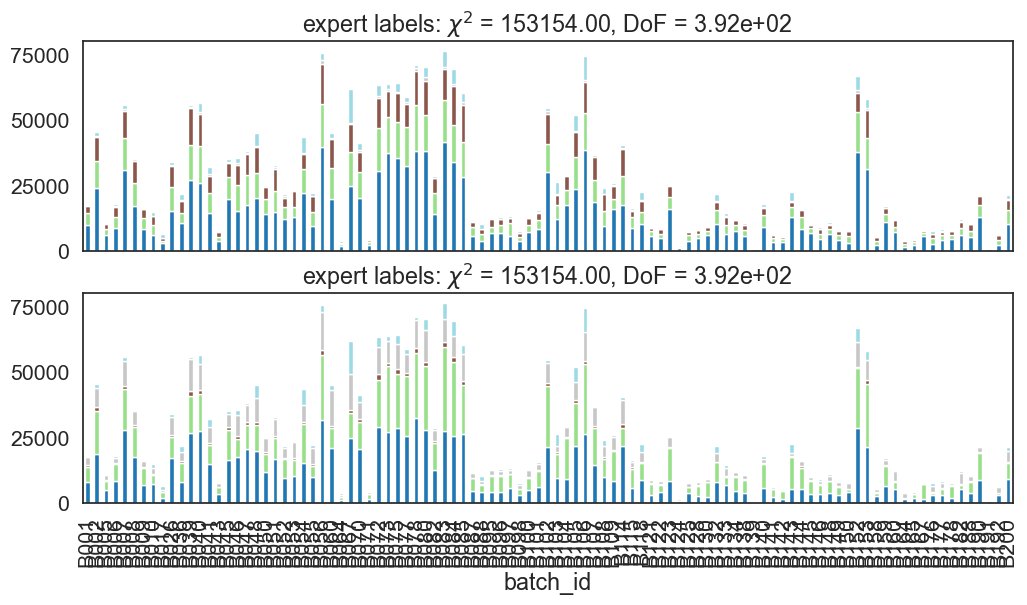

In [91]:
fig, ax = plt.subplots(2, 1, figsize = (10, 5), sharex = True)
ct = pd.crosstab(u_umap['batch_id'], u_umap['AIFI_L3'])
ct.plot(kind='bar', stacked=True, figsize=(12,6), colormap='tab20', ax = ax[0], legend = False)
ct = pd.crosstab(u_umap['batch_id'], u_umap['partition'])
ct.plot(kind='bar', stacked=True, figsize=(12,6), colormap='tab20', ax = ax[1], legend = False)
ax[0].set_title('expert labels: $\chi^2$ = {:.2f}, DoF = {:.2e}'.format(153154, 392))
ax[1].set_title('expert labels: $\chi^2$ = {:.2f}, DoF = {:.2e}'.format(153154, 392))

In [13]:
from sklearn.metrics import silhouette_samples
u_subset = umat.iloc[::50]

uspace_sil = silhouette_samples(u_subset.to_numpy(), u_umap.loc[u_subset.index, 'batch_id'])


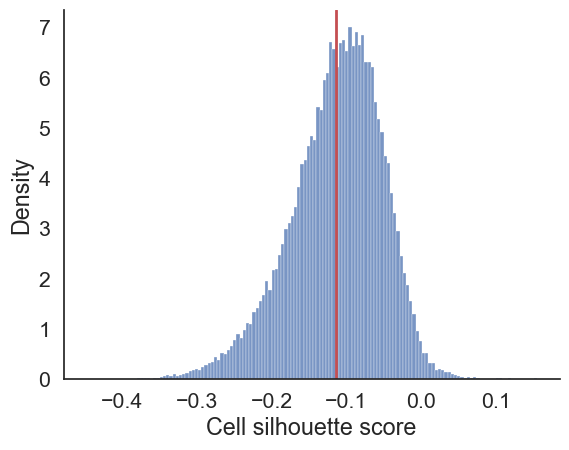

In [19]:
fig, ax = plt.subplots()
sns.set(style = 'white', font_scale = 0.5)
sns.histplot(uspace_sil, stat = 'density')
plt.axvline(uspace_sil.mean(), color = 'r',linewidth = 2)
#plt.text(-.1, 7.1, f'Mean: {uspace_sil.mean():.2f}', color = 'k', ha = 'left')
plt.xlabel('Cell silhouette score')
sns.despine()

# differential abundance analysis

## cluster differences between age groups

In [5]:
from scipy.stats import gmean
import numpy as np
#obs['partition'] = u_umap.loc[obs.index, 'partition']
part_counts = pd.pivot_table(adata.obs.groupby('sample.sampleKitGuid')['partition'].value_counts().reset_index(),
index = 'sample.sampleKitGuid', columns = 'partition', values = 'count').fillna(0)
part_counts.columns = ['C'+ str(x) for x in part_counts.columns]

part_counts_clr = part_counts.replace(0, 1/2)
part_counts_clr = np.log(part_counts_clr.transpose() / gmean(part_counts_clr, axis=1)).transpose()
sample_meta = adata.obs[['sample.sampleKitGuid','subject.subjectGuid', 'subject.biologicalSex',
       'subject.cmv', 'subject.bmi', 'subject.race', 'subject.ethnicity',
       'subject.ageAtFirstDraw', 'sample.visitName', 'sample.drawYear',
       'sample.subjectAgeAtDraw', 
       'subject.ageGroup']].drop_duplicates(subset = \
        'sample.sampleKitGuid').set_index('sample.sampleKitGuid')

/var/folders/_p/0rhlx8c56pgffwnwkjz824s80000gn/T/ipykernel_11951/692814571.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  part_counts = pd.pivot_table(adata.obs.groupby('sample.sampleKitGuid')['partition'].value_counts().reset_index(),
/var/folders/_p/0rhlx8c56pgffwnwkjz824s80000gn/T/ipykernel_11951/692814571.py:4: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  part_counts = pd.pivot_table(adata.obs.groupby('sample.sampleKitGuid')['partition'].value_counts().reset_index(),


/var/folders/_p/0rhlx8c56pgffwnwkjz824s80000gn/T/ipykernel_11951/3440499358.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = sorted_pdf.groupby('subject.ageGroup')
/var/folders/_p/0rhlx8c56pgffwnwkjz824s80000gn/T/ipykernel_11951/3440499358.py:30: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0' has dtype incompatible with category, please explicitly cast to a compatible dtype first.
  blank.iloc[:, :] = 0
/var/folders/_p/0rhlx8c56pgffwnwkjz824s80000gn/T/ipykernel_11951/3440499358.py:30: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0' has dtype incompatible with category, please explicitly cast to a compatible dtype first.
  blank.iloc[:, :] 

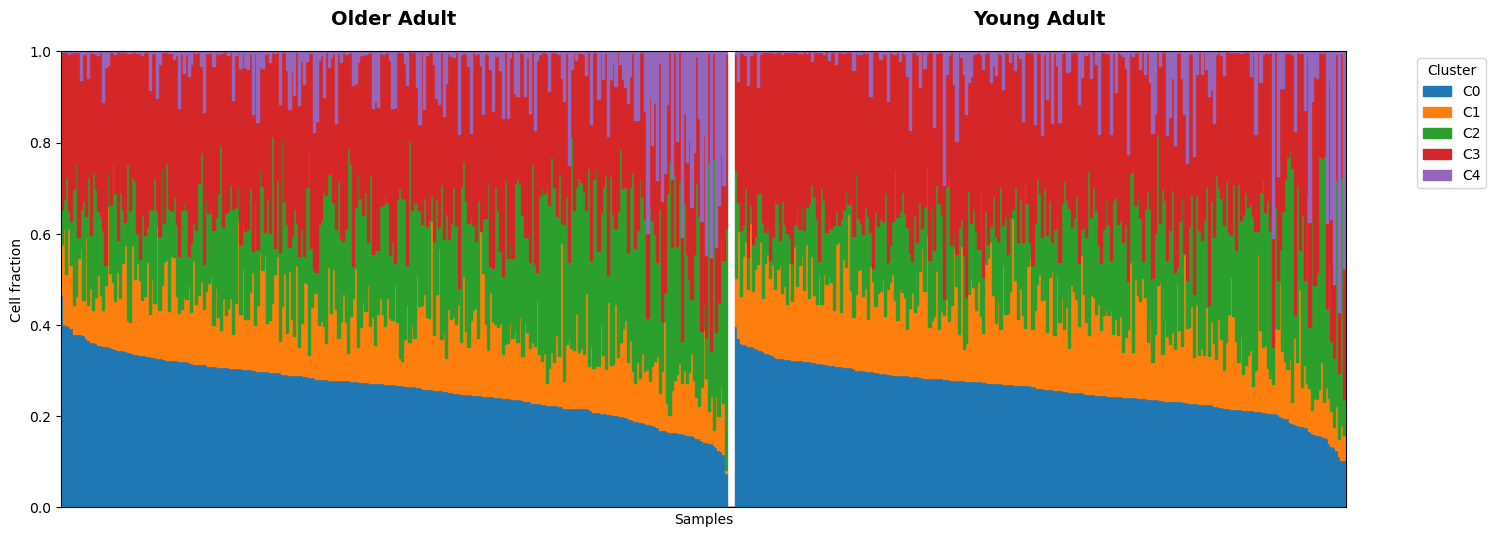

In [6]:
pdf = (part_counts.transpose() / part_counts.sum(axis = 1)).transpose()
pdf = pdf.join(sample_meta[~sample_meta['sample.visitName'].isin(['Flu Year 1 Day 7', 'Flu Year 1 Day 90', 'Flu Year 2 Day 7', 'Flu Year 2 Day 90',
'Flu Year 3 Day 7', 'Flu Year 3 Day 90'])][['subject.subjectGuid', 'subject.ageGroup']]).dropna()

import matplotlib.pyplot as plt

# Specify partitions to plot
partitions = ['C0', 'C1', 'C2', 'C3', 'C4']

# Drop any rows with missing values in partitions or age group
pdf_plot = pdf.dropna(subset=partitions + ['subject.ageGroup']).copy()

# --- White space logic start ---
pdf_plot['sortgrp'] = pdf_plot['subject.ageGroup']
sorted_pdf = pdf_plot.sort_values(['subject.ageGroup', 'C0'], ascending=[True, False])

grouped = sorted_pdf.groupby('subject.ageGroup')
group_order = []
spacer_count = 3   # Number of "white space" samples between groups; adjust as desired
white_space_pdf = []
group_names = []
for grp, group_df in grouped:
    group_order.extend(group_df.index.tolist())
    white_space_pdf.append(group_df)
    group_names.append(grp)
    if grp != list(grouped.groups.keys())[-1]:
        # construct empty rows, using same columns as group_df, indexed by fake sample names
        blank = group_df.head(spacer_count).copy()
        blank[partitions] = 0
        blank.iloc[:, :] = 0
        blank.index = [f"_spacer_{grp}_{i}" for i in range(spacer_count)]
        white_space_pdf.append(blank)

plot_pdf = pd.concat(white_space_pdf)
plot_idx = np.arange(len(plot_pdf))

is_spacer = plot_pdf.index.str.startswith('_spacer_')
# --- White space logic end ---

# Prepare data for stacked barplot
bottom = np.zeros(len(plot_pdf))
bar_width = 0.9

fig, ax = plt.subplots(figsize=(15, 5))

# Use a qualitative color palette for bars that does not include light colors with white edge
import seaborn as sns
palette = sns.color_palette("tab10", n_colors=5)
colors = palette[:5]

for idx, (col, color) in enumerate(zip(partitions, colors)):
    vals = plot_pdf[col].values
    ax.bar(
        plot_idx, vals, bar_width, bottom=bottom, label=col, color=color, edgecolor=color  # Set edgecolor=same as facecolor
    )
    bottom += vals

# Formatting (no white edge visible)
ax.set_xticks([])
ax.set_xlabel("")
ax.set_ylabel("Cell fraction")
ax.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.xlim(0, len(plot_pdf))
# Add group labels above the plot for "Older Adult" (before spacers) and "Young Adult" (after spacers)
# Find the index ranges for each group excluding spacers
group_mask = ~plot_pdf.index.str.startswith('_spacer_')

# Get group name and range (assuming only two groups in group_names)
if len(group_names) == 2:
    # Find indexes of each group in plot_pdf
    group1_name = group_names[0]
    group2_name = group_names[1]
    group1_mask = plot_pdf.index.isin(grouped.get_group(group1_name).index)
    group2_mask = plot_pdf.index.isin(grouped.get_group(group2_name).index)
    # Get the center position above each group for annotation
    group1_pos = np.where(group1_mask)[0]
    group2_pos = np.where(group2_mask)[0]
    if len(group1_pos) > 0:
        xpos1 = (group1_pos[0] + group1_pos[-1]) / 2
        ax.annotate("Older Adult", xy=(xpos1, 1.05), xycoords=('data', 'axes fraction'),
                    ha='center', va='bottom', fontsize=14, fontweight='bold')
    if len(group2_pos) > 0:
        xpos2 = (group2_pos[0] + group2_pos[-1]) / 2
        ax.annotate("Young Adult", xy=(xpos2, 1.05), xycoords=('data', 'axes fraction'),
                    ha='center', va='bottom', fontsize=14, fontweight='bold')

plt.xlabel('Samples')

plt.show()
fig.savefig('figures/stacked_barplot_by_age.pdf', dpi = 300, bbox_inches = 'tight', format = 'pdf', transparent = True)

In [8]:
pdf.drop(columns = ['subject.subjectGuid']).groupby('subject.ageGroup').corr()

/var/folders/_p/0rhlx8c56pgffwnwkjz824s80000gn/T/ipykernel_11951/766926278.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pdf.drop(columns = ['subject.subjectGuid']).groupby('subject.ageGroup').corr()


C0        C1        C2        C3        C4
subject.ageGroup                                                           
Sound Life Older Adult C0  1.000000  0.151244 -0.439456  0.374913 -0.502007
                       C1  0.151244  1.000000 -0.645490  0.167378 -0.039515
                       C2 -0.439456 -0.645490  1.000000 -0.494786 -0.215267
                       C3  0.374913  0.167378 -0.494786  1.000000 -0.459796
                       C4 -0.502007 -0.039515 -0.215267 -0.459796  1.000000
Sound Life Young Adult C0  1.000000  0.328358 -0.521647  0.310756 -0.399842
                       C1  0.328358  1.000000 -0.581179  0.114931 -0.266904
                       C2 -0.521647 -0.581179  1.000000 -0.425119 -0.198261
                       C3  0.310756  0.114931 -0.425119  1.000000 -0.469566
                       C4 -0.399842 -0.266904 -0.198261 -0.469566  1.000000

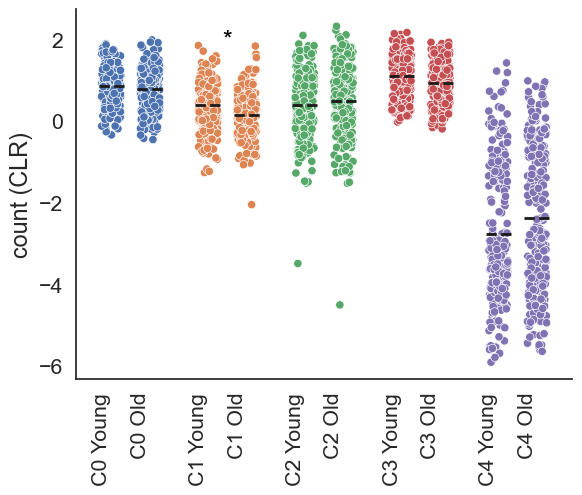

In [133]:
pdf = part_counts_clr.copy().join(sample_meta[~sample_meta['sample.visitName'].isin([
    'Flu Year 1 Day 7', 'Flu Year 1 Day 90', 'Flu Year 2 Day 7', 'Flu Year 2 Day 90',
    'Flu Year 3 Day 7', 'Flu Year 3 Day 90'
])]).dropna()
pdf = pd.melt(
    pdf,
    id_vars='subject.ageGroup',
    value_vars=part_counts_clr.columns,
    var_name='partition',
    value_name='clr_count'
)
pdf['x'] = pdf['partition'].apply(lambda x: int(x[1]))
pdf['x'] = pdf.apply(
    lambda row: row['x'] - 0.2 if row['subject.ageGroup'] == 'Sound Life Young Adult' else row['x'] + 0.2,
    axis=1
)
pdf['x'] = pdf['x'].apply(lambda x: x + np.random.uniform(-0.1, 0.1))

ax = sns.scatterplot(data=pdf, x='x', hue='partition', y='clr_count', legend=False)
sns.despine()

# Draw lines for means
for partition in sorted(pdf['partition'].unique(), key=lambda k: int(k[1])):
    for group, group_label, offset in zip(
        ['Sound Life Young Adult', 'Sound Life Older Adult'],
        ['Young', 'Old'],
        [-0.2, +0.2],
    ):
        sub = pdf.loc[(pdf['partition'] == partition) & (pdf['subject.ageGroup'] == group)]
        mean_val = sub['clr_count'].mean()
        xpos = int(partition[1]) + offset
        ax.hlines(mean_val, xpos - 0.13, xpos + 0.13, color='k', lw=2, zorder=10, linestyle = '--')

xticks = [0, 1, 2, 3, 4]
xticks = [[x - 0.2, x + 0.2] for x in xticks]
xticks = [item for sublist in xticks for item in sublist]
labels = ['C0', 'C1', 'C2', 'C3', 'C4']
labels = [[x + ' Young', x + ' Old'] for x in labels]
labels = [item for sublist in labels for item in sublist]

plt.xticks(xticks, labels, rotation=90, ha='right')
plt.xlabel('')
plt.ylabel('count (CLR)')
# Add an asterisk above x=1 (the "C1" positions, i.e., x=0.8 for Young, x=1.2 for Old)
# Find the max clr_count for C1 (partition == 'C1' for both age groups)

plt.text(1, 1.7, '*', ha='center', va='bottom', color='black', fontsize=18)

plt.show()

In [ ]:
import statsmodels.formula.api as smf
clust = 'C0'
allres = []
for clust in part_counts_clr.columns:
    data = part_counts_clr[[clust]].join(sample_meta[~sample_meta['sample.visitName'].isin(['Flu Year 1 Day 7', 'Flu Year 1 Day 90', 
    'Flu Year 2 Day 7', 'Flu Year 2 Day 90',
'Flu Year 3 Day 7', 'Flu Year 3 Day 90'])]).dropna(subset  = ['subject.subjectGuid'])
    data.rename(columns = {clust: 'partition', 'subject.ageGroup': 'age_group',
    'subject.subjectGuid': 'subject'}, inplace = True)
    fit = smf.mixedlm('partition ~ C(age_group, Treatment(reference="Sound Life Older Adult"))', data = data, groups = 'subject').fit()
    #fit = smf.ols('partition ~ age_group', data = data).fit()
    # Get age group coefficient, p-value, and number of observations
    coef = fit.params.get('C(age_group, Treatment(reference="Sound Life Older Adult"))[T.Sound Life Young Adult]', float('nan'))
    pvalue = fit.pvalues.get('C(age_group, Treatment(reference="Sound Life Older Adult"))[T.Sound Life Young Adult]', float('nan'))
    nobs = fit.nobs
    allres.append({'cluster': clust, 'coef': coef, 'pvalue': pvalue, 'nobs': nobs})

    if float(fit.pvalues['C(age_group, Treatment(reference="Sound Life Older Adult"))[T.Sound Life Young Adult]']) < 0.05:
        print(clust)
        print(fit.summary())

# summary 
import pandas as pd
allres_df = pd.DataFrame(allres)
display(allres_df)

C1
                                            Mixed Linear Model Regression Results
Model:                                     MixedLM                        Dependent Variable:                        partition
No. Observations:                          521                            Method:                                    REML     
No. Groups:                                96                             Scale:                                     0.1337   
Min. group size:                           1                              Log-Likelihood:                            -318.2643
Max. group size:                           6                              Converged:                                 Yes      
Mean group size:                           5.4                                                                                
------------------------------------------------------------------------------------------------------------------------------
                          

,cluster,coef,pvalue,nobs
0,C0,0.041586,0.660690,521
1,C1,0.206765,0.028364,521
2,C2,-0.127810,0.275381,521
3,C3,0.118673,0.219725,521
4,C4,-0.211894,0.544141,521


## changes after vaccination

In [16]:
long_meta = sample_meta.copy()
regroup = {'Flu Year 1 Day 0': 0, 'Flu Year 1 Day 7': 1,
'Flu Year 2 Day 0': 0, 'Flu Year 2 Day 7': 1}
long_meta = long_meta[long_meta['sample.visitName'].isin(regroup.keys())]
long_meta['trial_date'] = long_meta['sample.visitName'].map(regroup)
long_meta.drop(columns = ['sample.visitName'], inplace = True)
long_meta['event'] = long_meta['subject.subjectGuid'].astype(str)\
         + '_' + long_meta['sample.drawYear'].astype(str)
long_meta.drop(columns = ['sample.drawYear', 'subject.subjectGuid'], inplace = True)
long_meta.rename(columns = {'subject.ageGroup': 'age_group'}, inplace = True)
data = part_counts_clr.join(long_meta).dropna()
fit = smf.mixedlm('C0 ~ trial_date*age_group', data = data, groups = 'event').fit()
fit.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Mixed Linear Model Regression Results
========================================================================================
Model:                        MixedLM            Dependent Variable:            C0      
No. Observations:             336                Method:                        REML    
No. Groups:                   165                Scale:                         0.0172  
Min. group size:              2                  Log-Likelihood:                -82.1661
Max. group size:              4                  Converged:                     Yes     
Mean group size:              2.0                                                       
----------------------------------------------------------------------------------------
                                               Coef. Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------------------
Intercept                                      0.764    0.055 13.843 0.000  0.656  0.872
age_group[T.Sound Life Young Adult]            0.071    0.080  0.892 0.372 -0.085  0.227
trial_date                                     0.007    0.020  0.356 0.722 -0.032  0.046
trial_date:age_group[T.Sound Life Young Adult] 0.066    0.029  2.318 0.020  0.010  0.122
event Var                                      0.245    0.300                           
========================================================================================

"""

In [17]:
wide_data = long_meta[long_meta['trial_date'] == 0][['age_group', 
'trial_date', 'event']].reset_index().set_index('event').rename(\
    columns = {'sample.sampleKitGuid': 's0'}).join(\
        long_meta[long_meta['trial_date'] == 1\
            ].reset_index().set_index('event'\
    )[['sample.sampleKitGuid']]).rename(columns = {'sample.sampleKitGuid': 's1'}).dropna()

wide_data = pd.merge(wide_data, part_counts_clr, left_on = 's0', right_index = True)
wide_data.rename(columns = {'C0': 's0_C0', 'C1': 's0_C1', 'C2': 's0_C2', 'C3': 's0_C3', 'C4': 's0_C4'}, inplace = True)
wide_data = pd.merge(wide_data, part_counts_clr, left_on = 's1', right_index = True)
wide_data.rename(columns = {'C0': 's1_C0', 'C1': 's1_C1', 'C2': 's1_C2', 'C3': 's1_C3', 'C4': 's1_C4'}, inplace = True)
wide_data['C0'] = wide_data['s1_C0'] - wide_data['s0_C0']
wide_data['C1'] = wide_data['s1_C1'] - wide_data['s0_C1']
wide_data['C2'] = wide_data['s1_C2'] - wide_data['s0_C2']
wide_data['C3'] = wide_data['s1_C3'] - wide_data['s0_C3']
wide_data['C4'] = wide_data['s1_C4'] - wide_data['s0_C4']
wide_data.drop(columns = ['s0_C0', 's0_C1', 's0_C2', 's0_C3', 's0_C4', 's1_C0', 's1_C1', 's1_C2', 's1_C3', 's1_C4'], inplace = True)
wide_data =pd.merge(wide_data, sample_meta[['subject.subjectGuid']], left_on = 's0', right_index = True)


0 Sound Life Young Adult -0.35 -0.04999999999999999 0.06475078503352558
0 Sound Life Older Adult 0.05 0.35 0.005728332963394726
1 Sound Life Young Adult 0.65 0.95 0.04764053345853157
1 Sound Life Older Adult 1.05 1.35 -0.006970874372527863
2 Sound Life Young Adult 1.65 1.95 -0.08550230230318705
2 Sound Life Older Adult 2.05 2.3499999999999996 -0.08164553409678604
3 Sound Life Young Adult 2.65 2.9499999999999997 0.07073882764007537
3 Sound Life Older Adult 3.05 3.3499999999999996 0.00952246623922089
4 Sound Life Young Adult 3.65 3.9499999999999997 -0.09762784382894571
4 Sound Life Older Adult 4.05 4.35 0.07336560926669806


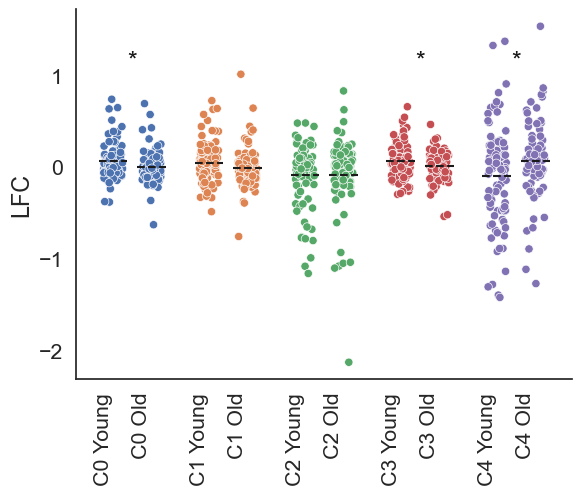

In [147]:
pdf = pd.melt(wide_data[['C0', 'C1', 'C2', 'C3', 'C4', 'age_group']],
id_vars = ['age_group'], var_name = 'type', value_name = 'LFC')
pdf['x'] = pdf['type'].apply(lambda x: int(x[1]))
pdf['x'] = pdf.apply(lambda x: x['x'] - 0.2 if x['age_group'] \
    == 'Sound Life Young Adult' else x['x'] + 0.2, axis = 1)
pdf['x'] = pdf['x'].apply(lambda x: x+ np.random.uniform(-0.1, 0.1))
sns.scatterplot(data = pdf, x = 'x', hue = 'type', y = 'LFC', legend = False)
for i in range(5):
    for j in ['Sound Life Young Adult', 'Sound Life Older Adult']:
        xmin = i
        if 'oung' in j:
            xmin -= .35
        else:
            xmin += .05
        xmax = xmin + 0.3
        
        y = pdf[(pdf['type'] == 'C'+str(i)) & (pdf['age_group'] == j)]['LFC'].mean()
        print(i, j, xmin, xmax, y)
        plt.plot([xmin, xmax], [y, y], color = 'k', linestyle = '--')

sns.despine()
plt.ylabel('LFC')

xticks = [0,1,2,3,4]
xticks = [[x-0.2, x+0.2] for x in xticks]
xticks = [item for sublist in xticks for item in sublist]
labels = ['C0', 'C1', 'C2', 'C3', 'C4']
labels = [ [x+ ' Young', x+ ' Old'] for x in labels]
labels = [item for sublist in labels for item in sublist]

plt.xticks(xticks, labels, rotation = 90, ha = 'right')
plt.xlabel('')

plt.text(0, 1.03, '*', ha='center', va='bottom', fontsize=18, color='k')
plt.text(3, 1.03, '*', ha='center', va='bottom', fontsize=18, color='k')
plt.text(4, 1.03, '*', ha='center', va='bottom', fontsize=18, color='k')

plt.show()

In [144]:
import statsmodels.formula.api as smf

results = []

for clust in part_counts_clr.columns:
    data = wide_data.copy()
    data.rename(columns = {clust: 'partition', 'subject.ageGroup': 'age_group',
    'subject.subjectGuid': 'subject'}, inplace = True)
    fit = smf.ols('partition ~ age_group', data = data).fit()
    # Extract beta (coefficient) and p-value for the age_group
    beta = fit.params.get('age_group[T.Sound Life Young Adult]', float('nan'))
    pvalue = fit.pvalues.get('age_group[T.Sound Life Young Adult]', float('nan'))
    results.append({'clust': clust, 'beta': beta, 'pvalue': pvalue})

results_df = pd.DataFrame(results)

In [25]:
wide_data.groupby('age_group')[['C0', 'C1', 'C2', 'C3', 'C4']].mean().transpose().set_index('Sound Life Older Adult')

/var/folders/_p/0rhlx8c56pgffwnwkjz824s80000gn/T/ipykernel_11951/1276736857.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  wide_data.groupby('age_group')[['C0', 'C1', 'C2', 'C3', 'C4']].mean().transpose().set_index('Sound Life Older Adult')


age_group,Sound Life Young Adult
Sound Life Older Adult,
0.005728,0.064751
-0.006971,0.047641
-0.081646,-0.085502
0.009522,0.070739
0.073366,-0.097628


In [145]:
results_df

,clust,beta,pvalue
0,C0,0.059022,0.030932
1,C1,0.054611,0.095821
2,C2,-0.003857,0.942102
3,C3,0.061216,0.018686
4,C4,-0.170993,0.017704
